In [0]:
from __future__ import unicode_literals, print_function, division

import pandas as pd
import logging
import glob
from sklearn.model_selection import train_test_split
from io import open
import unicodedata
import string
import re
import random
import pickle
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
%matplotlib inline
import numpy as np
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace

CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0')

In [0]:
class seq2seq(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        """Take in and process masked src and target sequences."""
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)
    
    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
               decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                            src_mask, trg_mask, hidden=decoder_hidden)

In [0]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [0]:
class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)
        
    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        """
        packed = pack_padded_sequence(x, lengths, batch_first=True)
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)

        # we need to manually concatenate the final states for both directions
        fwd_final = final[0:final.size(0):2]
        bwd_final = final[1:final.size(0):2]
        final = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]

        return output, final

In [0]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    
    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
                 
        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
                 
        # to initialize from the final encoder state
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None

        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                          hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        """Perform a single decoder step (1 word)"""

        # compute context vector using attention mechanism
        query = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]
        context, attn_probs = self.attention(
            query=query, proj_key=proj_key,
            value=encoder_hidden, mask=src_mask)

        # update rnn hidden state
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        
        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output
    
    def forward(self, trg_embed, encoder_hidden, encoder_final, 
                src_mask, trg_mask, hidden=None, max_len=None):
        """Unroll the decoder one step at a time."""
                                         
        # the maximum number of steps to unroll the RNN
        if max_len is None:
            max_len = trg_mask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)
        
        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)
        
        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []
        
        # unroll the decoder RNN for max_len steps
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(
              prev_embed, encoder_hidden, src_mask, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  # [B, N, D]

    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoder_final is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoder_final))       

In [0]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()
        
        # We assume a bi-directional encoder so key_size is 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        # to store attention scores
        self.alphas = None
        
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"

        # We first project the query (the decoder state).
        # The projected keys (the encoder states) were already pre-computated.
        query = self.query_layer(query)
        
        # Calculate scores.
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        
        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas        
        
        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas, value)
        
        # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
        return context, alphas

In [0]:
def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    """Helper: Construct a model from hyperparameters."""

    attention = BahdanauAttention(hidden_size)

    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size, tgt_vocab))

    return model.cuda() if USE_CUDA else model

In [0]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):
        
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        
        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()

In [0]:
def run_epoch(data_iter, model, loss_compute, print_every=50):
    """Standard Training and Logging Function"""

    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0

    for i, batch in enumerate(data_iter, 1):
        out, _, pre_output = model.forward(batch.src, batch.trg,
                                           batch.src_mask, batch.trg_mask,
                                           batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens
        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.nseqs, print_tokens / elapsed))
            start = time.time()
            print_tokens = 0

    return math.exp(total_loss / float(total_tokens))

In [0]:
def print_examples(example_iter, model, n=2, max_len=100, 
                   sos_index=1, 
                   src_eos_index=None, 
                   trg_eos_index=None, 
                   src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
        
    for i, batch in enumerate(example_iter):
        if(i % 2 == 0):
            continue
        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg      
      
        result, _ = greedy_decode(
          model, batch.src, batch.src_mask, batch.src_lengths,
          max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (count+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()
        count += 1
        if count == n:
            break

In [0]:


def data_gen(num_words=11, batch_size=16, num_batches=100, length=10, pad_index=0, sos_index=1):
    """Generate random data for a src-tgt copy task."""
    for i in range(num_batches):
        data = torch.from_numpy(
          np.random.randint(1, num_words, size=(batch_size, length)))
        data[:, 0] = sos_index
        data = data.cuda() if USE_CUDA else data
        src = data[:, 1:]
        trg = data
        src_lengths = [length-1] * batch_size
        trg_lengths = [length] * batch_size
        yield Batch((src, src_lengths), (trg, trg_lengths), pad_index=pad_index)

In [0]:
class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

In [0]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    """Incrementally decode a sentence."""

    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    
    output = np.array(output)
        
    # cut off everything starting from </s> 
    # (only when eos_index provided)
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output, np.concatenate(attention_scores, axis=1)
  

def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

In [0]:


def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)


In [0]:
#pip install https://github.com/pytorch/text/archive/master.zip
#!python -m spacy download en

In [0]:
from torchtext import data, datasets


In [0]:
import en_core_web_sm



In [0]:
en = en_core_web_sm.load()

In [0]:

if True:
    import spacy
    spacy_en = spacy.load('en_core_web_sm')

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    UNK_TOKEN = "<unk>"
    PAD_TOKEN = "<pad>"    
    SOS_TOKEN = "<s>"
    EOS_TOKEN = "</s>"
    LOWER = True
    
    # we include lengths to provide to the RNNs
    SRC = data.Field(tokenize=tokenize_en, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
    
    TRG = data.Field(tokenize=tokenize_en, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

    MAX_LEN_SRC = 500  # NOTE: we filter out a lot of sentences for speed
    MAX_LEN_TRG = 25  # NOTE: we filter out a lot of sentences for speed
    
    #train_data = data.TabularDataset(path='train.csv', format='csv',
    #                        fields=[('src', SRC), ('trg', TRG)], 
    #                        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN_SRC and len(vars(x)['trg']) <= MAX_LEN_TRG)
    train_data, valid_data, test_data = data.TabularDataset.splits(path='data/',train='train.csv',
                                        validation='val.csv', test='test.csv', format='csv',
                                        fields=[('src', SRC), ('trg', TRG)],
                                        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN_SRC 
                                        and len(vars(x)['trg']) <= MAX_LEN_TRG)
    
    MIN_FREQ_SRC = 100  # NOTE: we limit the vocabulary to frequent words for speed
    MIN_FREQ_TRG = 10  # NOTE: we limit the vocabulary to frequent words for speed

    SRC.build_vocab(train_data.src, min_freq=MIN_FREQ_SRC)
    TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ_TRG)
    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]

In [0]:
train_data

In [0]:
def print_data_info(train_data, valid_data, test_data, src_field, trg_field):
    """ This prints some useful stuff about our data sets. """

    print("Data set sizes (number of sentence pairs):")
    print('train', len(train_data))
    print('valid', len(valid_data))
    print('test', len(test_data), "\n")

    print("First training example:")
    print("src:", " ".join(vars(train_data[0])['src']))
    print("trg:", " ".join(vars(train_data[0])['trg']), "\n")
    
    print("Most common words (src):")
    print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")
    print("Most common words (trg):")
    print("\n".join(["%10s %10d" % x for x in trg_field.vocab.freqs.most_common(10)]), "\n")

    print("First 10 words (src):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")
    print("First 10 words (trg):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(trg_field.vocab.itos[:10])), "\n")

    print("Number of text words (types):", len(src_field.vocab))
    print("Number of title words (types):", len(trg_field.vocab), "\n")
    
    
print_data_info(train_data, valid_data, test_data,   SRC, TRG)

Data set sizes (number of sentence pairs):
train 152901
valid 42613
test 22087 

First training example:
src: zuzu verk student sul ross state university alpine texas last heard early hours oct night friends boyfriend assistance texas rangers fbi authorities launched massive search verk scouring square miles air land search missing daughter piano guys pianist verk father glenn told foxnews com monday young woman boyfriend name cooperated police family someone care missing help said verk whose lives seven hours away keller worth suburb daughter grew police believe body found river likely missing new hampshire teen drove night soon heard zuzu missing got search already progress said everyone wanted help verk boyfriend alpine police department posted photo sunday white ford mustang said key piece evidence disappearance verk considerd possibly endangered missing person photos car posted department facebook page authorities said conducting forensic exam another vehicle grey ford investigato

In [0]:

batch_size = 36

In [0]:
train_iter = data.BucketIterator(train_data, batch_size=batch_size, train=True, 
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=DEVICE)




In [0]:
valid_iter = data.Iterator(valid_data, batch_size=1, train=False, sort=False, repeat=False, 
                           device=DEVICE)

In [0]:
def rebatch(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch(batch.src, batch.trg, pad_idx)

In [0]:
def train(model, num_epochs=50, lr=0.0003, print_every=100):
    """Train a model on IWSLT"""
    
    if USE_CUDA:
        model.cuda()

    # optionally add label smoothing; see the Annotated Transformer
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []

    for epoch in range(num_epochs):
      
        print("Epoch", epoch)
        torch.save(model.state_dict(), 'model_epoch_' + str(epoch+31))

        model.train()
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)
        
        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)        

            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
    torch.save(model.state_dict(), 'model_Final')

    return dev_perplexities

In [0]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=3, dropout=0.2)

model.load_state_dict(torch.load('model_epoch_30'))
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (rnn): GRU(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (key_layer): Linear(in_features=512, out_features=256, bias=False)
      (query_layer): Linear(in_features=256, out_features=256, bias=False)
      (energy_layer): Linear(in_features=256, out_features=1, bias=False)
    )
    (rnn): GRU(768, 256, num_layers=3, batch_first=True, dropout=0.2)
    (bridge): Linear(in_features=512, out_features=256, bias=True)
    (dropout_layer): Dropout(p=0.2, inplace=False)
    (pre_output_layer): Linear(in_features=1024, out_features=256, bias=False)
  )
  (src_embed): Embedding(22246, 256)
  (trg_embed): Embedding(11994, 256)
  (generator): Generator(
    (proj): Linear(in_features=256, out_features=11994, bias=False)
  )
)

In [0]:
#dev_perplexities = train(model,num_epochs=10, print_every=500)

In [0]:
'''
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=3, dropout=0.2)
valid_iter = data.BucketIterator(train_data, batch_size=batch_size, train=False, 
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=DEVICE)'''

In [0]:
'''criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
for i in range(21,31) :
    model.load_state_dict(torch.load('model_epoch_' + str(i)))
    model.eval()

    with torch.no_grad():       

        dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                   model, 
                                   SimpleLossCompute(model.generator, criterion, None),print_every=100)
        print("Validation perplexity epoch " + str(i) + " : %f" % dev_perplexity)
        dev_perplexities.append(dev_perplexity)'''

'criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)\nfor i in range(21,31) :\n    model.load_state_dict(torch.load(\'model_epoch_\' + str(i)))\n    model.eval()\n\n    with torch.no_grad():       \n\n        dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), \n                                   model, \n                                   SimpleLossCompute(model.generator, criterion, None),print_every=100)\n        print("Validation perplexity epoch " + str(i) + " : %f" % dev_perplexity)\n        dev_perplexities.append(dev_perplexity)'

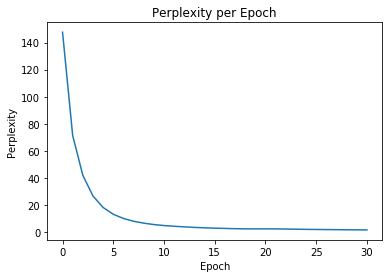

In [0]:
plot_perplexity(dev_perplexities)

In [0]:
len(dev_perplexities)

22

In [0]:
dev_perplexities

[12153.962785216369,
 147.59534763785604,
 71.36350288727262,
 42.06311264207203,
 26.79074113289264,
 18.344907590323828,
 13.351362039736333,
 10.260381394381353,
 8.203684167444424,
 6.798993646824806,
 5.7544551981463865,
 5.0189507900357295,
 4.504989100628449,
 4.044867465834432,
 3.661958507507502,
 3.3525864341170553,
 3.106094327018687,
 2.905105643298376,
 2.7100892564608334,
 2.5727233051610345,
 2.5727233051610345,
 2.5727233051610345,
 2.5727233051610345,
 2.4456663195442334,
 2.332940729946836,
 2.2232873511910047,
 2.1401892868423933,
 2.056830924356584,
 1.9839026938832418,
 1.912124019199619,
 1.8571811096179043,
 1.803490152134473]

In [0]:
model.load_state_dict(torch.load('model_epoch_30'))
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (rnn): GRU(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (key_layer): Linear(in_features=512, out_features=256, bias=False)
      (query_layer): Linear(in_features=256, out_features=256, bias=False)
      (energy_layer): Linear(in_features=256, out_features=1, bias=False)
    )
    (rnn): GRU(768, 256, num_layers=3, batch_first=True, dropout=0.2)
    (bridge): Linear(in_features=512, out_features=256, bias=True)
    (dropout_layer): Dropout(p=0.2, inplace=False)
    (pre_output_layer): Linear(in_features=1024, out_features=256, bias=False)
  )
  (src_embed): Embedding(22246, 256)
  (trg_embed): Embedding(11994, 256)
  (generator): Generator(
    (proj): Linear(in_features=256, out_features=11994, bias=False)
  )
)

In [0]:
test_iter = data.Iterator(test_data, batch_size=1, train=False, sort=False, repeat=False, 
                           device=DEVICE)

In [0]:
print_examples((rebatch(PAD_INDEX, x) for x in test_iter), 
               model, n=10, src_vocab=SRC.vocab, trg_vocab=TRG.vocab) 


Example #1
Src :  california governor jerry brown referred taxpayers <unk> last week objecting new gas tax car fee hikes <unk> enough president tell truth following suit said brown speaking orange county defending state assembly newcomer josh newman facing recall effort voting brown new transportation taxes april new tax raises existing gas taxes already among highest nation cents per gallon higher taxes diesel <unk> car owners higher annual registration fees critics pointed burden tax falls heavily californians orange county register covered brown remarks adds brown <unk> effort keep newman office whatever needs register quotes governor saying <unk> davis commenting <unk> remarks citizens los angeles county alone collect food stamps provided taxpayers <unk> millions illegal immigrants harbored california sanctuary cities cost taxpayers <unk> illegal immigrants provided free legal help state backs taxpayers <unk> <unk> sacramento legislature get paid day per <unk> funds top bloated sa

In [0]:
_, _, user_data = data.TabularDataset.splits(path='data/',train='news.csv',
                                    validation='news.csv', test='news.csv', format='csv',
                                    fields=[('src', SRC), ('trg', TRG)],
                                    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN_SRC 
                                    and len(vars(x)['trg']) <= MAX_LEN_TRG)


In [0]:
user_iter = data.Iterator(user_data, batch_size=1, train=False, sort=False, repeat=False, sort_within_batch=False,
                           device=DEVICE)

In [0]:
vars(user_data[0])['trg']

['house',
 'republicans',
 'fret',
 'about',
 'winning',
 'their',
 'health',
 'care',
 'suit',
 'the',
 'new',
 'york',
 'times']

In [0]:
print_examples((rebatch(PAD_INDEX, x) for x in user_iter), 
               model, n=1, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)


Example #1
Src :  washington congressional republicans new fear comes health care lawsuit obama administration might win incoming trump administration could choose longer defend executive branch suit challenges administration authority spend billions dollars health insurance subsidies americans handing house republicans big victory issues sudden loss disputed subsidies could conceivably cause health care program <unk> leaving millions people without access health insurance republicans prepared replacement could lead chaos insurance market spur political backlash republicans gain full control government stave outcome republicans could find awkward position <unk> huge sums temporarily prop obama health care law angering conservative voters demanding end law years another twist donald trump administration worried preserving executive branch <unk> could choose fight republican allies house central questions dispute eager avoid ugly political <unk> republicans capitol hill trump transition